In [17]:
# %pip install bing-image-downloader
from bing_image_downloader import downloader
import os
import shutil
import torch
import torch.nn as nn

import random
from pathlib import Path
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import pandas as pd
import time
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt


In [18]:
#set 1 to run the cell and 0 to skip
if 0:
    downloader.download(
        "dog",
        limit=100,
        output_dir="./dog",
        adult_filter_off=True,
        force_replace=False,
        timeout=60,
        verbose=True,
    )

In [19]:
if 0:
    downloader.download(
        "horse",
        limit=100,
        output_dir="./horse",
        adult_filter_off=True,
        force_replace=False,
        timeout=60,
        verbose=True,
    )

In [20]:
base_dir = Path("/home/rishabh.mondal/ml")
train_dir = base_dir / "train"
test_dir = base_dir / "test"
classes=['dog','horse']
source_dirs = {cls: base_dir / cls / cls for cls in classes}
print(source_dirs)
split_ratio = 0.8   
# Create train and test directories
for cls in classes:
    (train_dir / cls).mkdir(parents=True, exist_ok=True)
    (test_dir / cls).mkdir(parents=True, exist_ok=True)

# Split images and move to train/test directories
for cls in classes:
    images = list(source_dirs[cls].glob("*.jpg"))  # adjust pattern if necessary
    random.shuffle(images)
    split_idx = int(len(images) * split_ratio)
    train_images, test_images = images[:split_idx], images[split_idx:]
    
    for img_path in train_images:
        shutil.move(str(img_path), str(train_dir / cls / img_path.name))
    
    for img_path in test_images:
        shutil.move(str(img_path), str(test_dir / cls / img_path.name))

{'dog': PosixPath('/home/rishabh.mondal/ml/dog/dog'), 'horse': PosixPath('/home/rishabh.mondal/ml/horse/horse')}


In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor() 
])
train_dataset = datasets.ImageFolder(root=str(train_dir), transform=transform)
test_dataset = datasets.ImageFolder(root=str(test_dir), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Classes: {train_dataset.classes}")
example_img, label = train_dataset[0]
print(f"Image size: {example_img.size()}, Label: {train_dataset.classes[label]}")


Classes: ['dog', 'horse']
Image size: torch.Size([3, 224, 224]), Label: dog


In [22]:
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])
train_dataset_augmented = datasets.ImageFolder(root='/home/rishabh.mondal/ml/train', transform=augment_transform)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)


In [23]:

class VGG1Block(nn.Module):
    def __init__(self, num_classes=2):  
        super(VGG1Block, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64 * 112 * 112, 512),  
            nn.ReLU(),
            nn.Linear(512, num_classes)    
        )

    def forward(self, x):
        out = self.layer1(x)
        # print("Output size after layer1:", out.size()) 
        out = out.view(out.size(0), -1)  
        # print("Flattened output size:", out.size()) 
        out = self.layer2(out)  
        return out


# vgg with 3 blocks
class VGG3Blocks(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG3Blocks, self).__init__()
        # First block
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64 x 112 x 112
        )
        # Second block
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 128 x 56 x 56
        )
        # Third block
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256 x 28 x 28
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out



class TransferLearningVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(TransferLearningVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)  
        # unfreeze the entire model
        for param in self.vgg16.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        return self.vgg16(x)
    


class TransferLearningVGG16_FinalMLP(nn.Module):
    def __init__(self, num_classes=2):
        super(TransferLearningVGG16_FinalMLP, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Freeze convolutional layers
        for param in self.vgg16.features.parameters():
            param.requires_grad = False  
    
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)  
        
    def forward(self, x):
        return self.vgg16(x)






In [24]:
model1_vgg1_block = VGG1Block(num_classes=2)
model2_vgg3_blocks = VGG3Blocks(num_classes=2)
model3_transfer_learning = TransferLearningVGG16(num_classes=2)
model4_transfer_learning_final_mlp = TransferLearningVGG16_FinalMLP(num_classes=2)


/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model1_vgg1_block.to(device)
model2_vgg3_blocks.to(device)
model3_transfer_learning.to(device)
model4_transfer_learning_final_mlp.to(device)



TransferLearningVGG16_FinalMLP(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inp

In [26]:
models = {
    "VGG1Block": model1_vgg1_block,
    "VGG3Block": model2_vgg3_blocks,
    "VGG3BlocksAugmented": model2_vgg3_blocks,
    "TransferLearningVGG16": model3_transfer_learning, 
    "TransferLearningVGG16MLP": model4_transfer_learning_final_mlp,
}


In [27]:
train_loaders = {
    "VGG1Block": train_loader,
    "VGG3Block": train_loader,
    "VGG3BlocksAugmented": train_loader_augmented,
    "TransferLearningVGG16": train_loader,
    "TransferLearningVGG16MLP": train_loader,
}

In [28]:
test_loaders = {
    "VGG1Block": test_loader,
    "VGG3Block": test_loader,
    "VGG3BlocksAugmented": test_loader,
    "TransferLearningVGG16": test_loader,
    "TransferLearningVGG16MLP": test_loader,
}

In [ ]:
results = pd.DataFrame(columns=["Model", "Training Time (s)", "Training Loss", "Training Accuracy (%)", "Testing Accuracy (%)", "Number of Parameters"])

loss_history = {}
accuracy_history = {}

def train_and_evaluate_model(model_name, model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    
    num_params = sum(p.numel() for p in model.parameters())
    writer = SummaryWriter(log_dir=f"runs/{model_name}")

    
    total_training_time = 0
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    epoch_losses = []
    epoch_accuracies = []
    iteration=0

    # Training phase
    model.train()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            accuracy=100*correct/labels.size(0)
            writer.add_scalar("Train Loss ",loss.item(),iteration)
            writer.add_scalar("Train Accuracy ",accuracy,iteration)
            iteration+=1
            # print(labels.size(0))
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        epoch_time = time.time() - epoch_start_time
        total_training_time += epoch_time
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        
        total_loss += epoch_loss
        total_correct += correct
        total_samples += total
        #print after 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Time: {epoch_time:.2f}s, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    avg_training_loss = total_loss / num_epochs
    avg_training_accuracy = 100 * total_correct / total_samples
    loss_history[model_name] = epoch_losses
    accuracy_history[model_name] = epoch_accuracies
    
    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx,(images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            total += labels.size(0)

            for i in range(images.size(0)):
                img=images[i].cpu().numpy()
                label=labels[i].item()
                pred=predicted[i].item()
                writer.add_image(f'{model_name}_Test_Image_{batch_idx*test_loader.batch_size+i}_GT_{label}_pred_{pred}',img, dataformats='CHW')

                writer.add_text(
                    f'{model_name}_Prediction_{batch_idx * test_loader.batch_size + i}',
                    f'Ground Truth: {label}, Prediction: {pred}'
                )

            test_accuracy = 100 * correct / total
            writer.add_scalar("Test Accuracy ",test_accuracy,iteration)
    writer.close()

            
    
    test_accuracy = 100 * correct / total
    print(f"Testing Accuracy: {test_accuracy:.2f}%")
    
    # Store results in the DataFrame
    results.loc[len(results)] = [model_name, total_training_time, avg_training_loss, avg_training_accuracy, test_accuracy, num_params]


In [30]:
# Train and evaluate each model with its respective loaders
for model_name, model in models.items():
    train_loader = train_loaders[model_name]
    test_loader = test_loaders[model_name]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_and_evaluate_model(model_name, model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

# Display the results table
print(results)

Epoch [10/20], Time: 10.90s, Loss: 1.4151, Accuracy: 96.55%
Epoch [20/20], Time: 10.13s, Loss: 0.0000, Accuracy: 100.00%
Testing Accuracy: 89.19%
Epoch [10/20], Time: 10.66s, Loss: 0.6386, Accuracy: 84.14%
Epoch [20/20], Time: 11.47s, Loss: 0.0251, Accuracy: 100.00%
Testing Accuracy: 78.38%
Epoch [10/20], Time: 30.15s, Loss: 0.2532, Accuracy: 89.66%
Epoch [20/20], Time: 31.35s, Loss: 0.0654, Accuracy: 97.93%
Testing Accuracy: 75.68%
Epoch [10/20], Time: 10.64s, Loss: 0.6744, Accuracy: 64.14%
Epoch [20/20], Time: 11.91s, Loss: 0.6599, Accuracy: 62.07%
Testing Accuracy: 48.65%
Epoch [10/20], Time: 11.08s, Loss: 0.0000, Accuracy: 100.00%
Epoch [20/20], Time: 11.85s, Loss: 0.1725, Accuracy: 99.31%
Testing Accuracy: 86.49%
                      Model  Training Time (s)  Training Loss  \
0                 VGG1Block         217.413559      23.268465   
1                 VGG3Block         218.097371       8.106375   
2       VGG3BlocksAugmented         597.248618       0.425354   
3     Transf

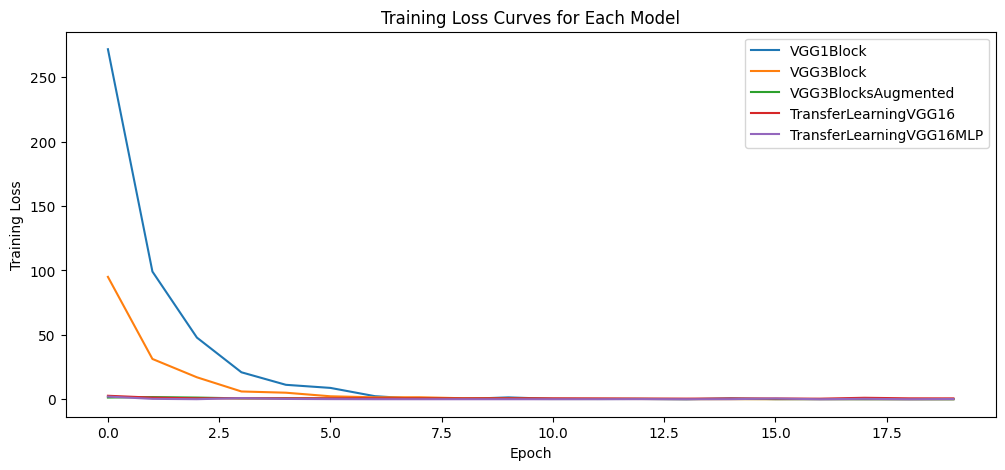

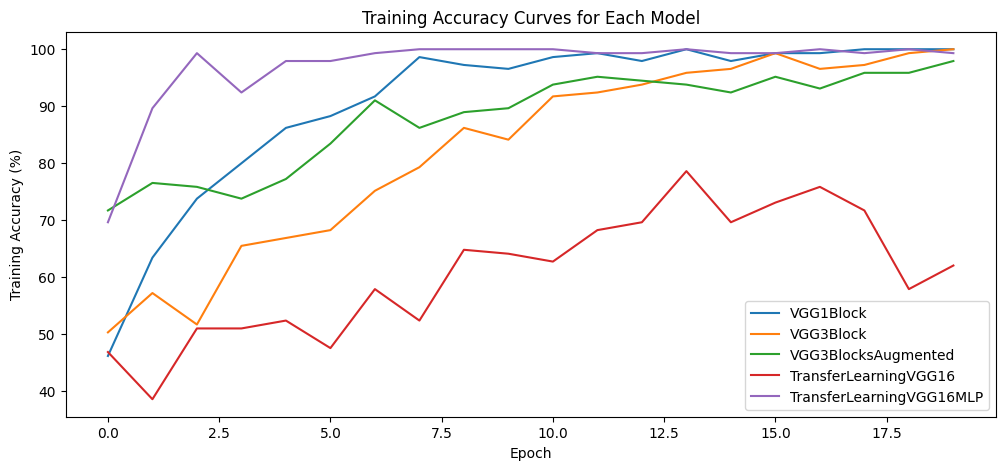

In [32]:
# Plot loss curves for each model
plt.figure(figsize=(12, 5))
for model_name, losses in loss_history.items():
    plt.plot(losses, label=model_name)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Each Model")
plt.legend()
plt.show()

# Plot accuracy curves for each model
plt.figure(figsize=(12, 5))
for model_name, accuracies in accuracy_history.items():
    plt.plot(accuracies, label=model_name)

plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy Curves for Each Model")
plt.legend()
plt.show()

In [ ]:
#plot the all test images and their predictions




In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP_VGG16_Comparable(nn.Module):
    def __init__(self, input_dim=3*224*224, hidden_dims=[4096, 4096, 2048, 1024, 512], output_dim=1000):
        super(MLP_VGG16_Comparable, self).__init__()
        
        layers = []
        # Input Layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
        
        # Hidden Layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
        
        # Output Layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

# Instantiate the model
input_dim = 3 * 224 * 224  # Image size for VGG-like input dimensions
hidden_dims = [4096, 4096, 2048, 1024, 512]  # Customize hidden layers
output_dim = 2  # Assuming classification over 1000 classes like ImageNet

mlp_model = MLP_VGG16_Comparable(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim)
print(f"Total parameters: {sum(p.numel() for p in mlp_model.parameters())}")


Total parameters: 644362754
